In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from linear2ac.io import get_main_data_folder

import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42


# Data load options and parameters

In [3]:
from pathlib import Path
main_folder = Path(get_main_data_folder())
data_folders = ['Tyche-A7 Set A-E','Tyche-A4 Set A-E','Tyche-A5 Set A-E']
cuesets = ['Cue Set A','Cue Set B','Cue Set C','Cue Set D', 'Cue Set E']

win_size = 25
accuracy_threshold = 75
sig_level = 0.05

# Process data.

In [4]:
import vr2p
from tqdm.notebook import tqdm

results = []
for data_folder in tqdm(data_folders,desc='Animal'):
   # load data.
    data = vr2p.ExperimentData(main_folder/data_folder)
    name=data.meta['animal']['name']
    # Collect VR data.
    vr_data = []
    for isession, vr in enumerate(data.vr):
        temp = vr.trial.copy()
        # add session number
        temp['session'] = isession
        temp = temp[['session','trial_number','set','reward_id','status','is_guided']]
        vr_data.append(temp)
    vr_data = pd.concat(vr_data)
    # go through cue sets.
    animal_results = []
    for cueset in cuesets:
        # select data related to cueset.
        cue_data = vr_data.loc[vr_data.set==cueset,:].copy()
        cue_data['cum_trial_number'] = np.arange(cue_data.shape[0])
        # set guided trials to Incorrect
        cue_data.loc[cue_data.is_guided,'status'] = 'INCORRECT'
        # Calculate rolling accuracy.
        cue_data['correct'] = cue_data['status']=='CORRECT'
        cue_data['accuracy'] = (cue_data.rolling(win_size,
            on='cum_trial_number',min_periods=win_size,center=False)['correct'].sum()/win_size)*100
        # find first accuracy occurence above threshold. 
        first_trial = cue_data[cue_data.accuracy >= accuracy_threshold]
        if first_trial.shape[0]>0:
            first_trial = first_trial.iloc[0]['cum_trial_number']
        else:
            first_trial = None
        animal_results.append(first_trial)
    results.append(animal_results)
results = np.array(results).astype(float)

Animal:   0%|          | 0/3 [00:00<?, ?it/s]

In [20]:
results[:,0:3]

array([[469.,  24., 252.],
       [638.,  46., 120.],
       [342.,  87., 477.]])

In [4]:
results_backup = results

# Calculate average performance and statistics.

In [5]:
from scipy.stats import ttest_rel

# Calculate averages scores.
m = np.nanmean(results,axis=0)
std = np.nanstd(results,axis=0)
sem = std/np.sqrt(np.count_nonzero(~np.isnan(results),axis=0))
# statistics.
for i, cueset_a in enumerate(cuesets):
    for j, cueset_b in enumerate(cuesets):
        t, p = ttest_rel(results[:,i],results[:,j],nan_policy='omit')
        if p<sig_level:
            print(f"{cueset_a} is signficantly different from {cueset_b}: {p}")

Cue Set A is signficantly different from Cue Set B: 0.047665215263230656
Cue Set A is signficantly different from Cue Set D: 0.025007121078194923
Cue Set A is signficantly different from Cue Set E: 0.028829775950403976
Cue Set B is signficantly different from Cue Set A: 0.047665215263230656
Cue Set D is signficantly different from Cue Set A: 0.025007121078194923
Cue Set E is signficantly different from Cue Set A: 0.028829775950403976


# Manual signficance indicators.
Need to be manually adjusted for changing settings.

In [6]:
sig_ind = [{'xpos': [0,4],'ypos':680,'symbol':'**'}]

# Plot

(0.0, 750.0)

findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.


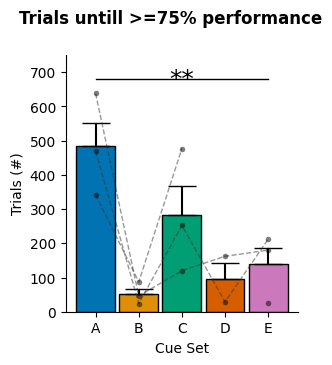

In [7]:
import figrid as fg
import matplotlib.pyplot as plt
from linear2ac.colors import cueset_color

grayscale = False

fig = plt.figure(figsize=(3,4),edgecolor='black',dpi=100,facecolor='white')
axs = {
    'plot': fg.place_axes_on_grid(fig, xspan=[0, 1], yspan=[0.15, 1]),
}
labels = [
    {'label_text':f"Trials untill >={accuracy_threshold}% performance", 'xpos':0.45,    'ypos':0.05, 'fontsize':12, 'weight': 'bold', 'ha': 'center', 'va': 'bottom'},
]
fg.add_labels(fig, labels)

# plot averages.
ax = axs['plot']
cueset_titles = [cueset.replace('Cue Set ','')for cueset in cuesets]
colors = cueset_color(cuesets,alpha=1)
if grayscale:
    colors='Gray'
ax.bar(cueset_titles, m, yerr=[np.zeros(sem.shape), sem], align='center', edgecolor='black', capsize=10, color = colors, width=0.9)
# plot individual animals.
for i in range(results.shape[0]):
    ax.plot(cueset_titles,results[i,:],color=(0.2,0.2,0.2,0.5),marker='o',
            markersize=4,markerfacecolor=(0,0,0,0.5),markeredgecolor=(0,0,0,0.5),markeredgewidth=0,
           linewidth=1,linestyle='--')
#plot signficance indicators
for sig in sig_ind:
    #plot line
    ax.plot(sig['xpos'],[sig['ypos'],sig['ypos']],linewidth=1,color='black')
    ax.text(sig['xpos'][0]+(sig['xpos'][1]-sig['xpos'][0])/2,sig['ypos'],sig['symbol'],ha='center',color='black',fontsize=18,fontname='arial',va='center')
#format axis.
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Cue Set')
ax.set_ylabel('Trials (#)')
ax.set_ylim(0,750)

In [44]:
results = results_backup

array([ 24., 252.,  29., 212.,  46., 120., 162., 180.,  87., 477.,  26.])

In [ ]:
import figrid as fg
import matplotlib.pyplot as plt
from linear2ac.colors import cueset_color
import numpy as np

grayscale = False
accuracy_threshold = 75

results_A = results[:,0].flatten()
results_new = results[:,1:].flatten()
results_new_no_nan  = results_new [~np.isnan(results_new )]


# Create figure and axes
fig = plt.figure(figsize=(3,4),edgecolor='black',dpi=100,facecolor='white')
axs = {
    'plot': fg.place_axes_on_grid(fig, xspan=[0, 1], yspan=[0.15, 1]),
}
labels = [
    {'label_text':f"Trials until >={accuracy_threshold}% performance", 'xpos':0.45, 'ypos':0.05, 'fontsize':12, 'weight': 'bold', 'ha': 'center', 'va': 'bottom'},
]
fg.add_labels(fig, labels)

# Define data
cueset_titles = ['A', 'New']
m_A = np.mean(results_A)
m_new = np.mean(results_new_no_nan)
sem_A = np.nanstd(results_A)/np.sqrt(len(results_A))
sem_new = np.nanstd(results_new)/np.sqrt(len(results_new_no_nan))



# plot averages.
ax = axs['plot']
#colors = cueset_color(cueset_titles,alpha=1)
if grayscale:
    colors='Gray'
ax.bar(cueset_titles, [m_A, m_new], yerr=[[0, 0], [sem_A, sem_new]], align='center', edgecolor='black', capsize=10, color = colors, width=0.9)


#format axis.
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Cue Set')
ax.set_ylabel('Trials (#)')
ax.set_ylim(0, 750)


/tmp/ipykernel_2546430/420753947.py:50: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig("bargraph.pdf", format='pdf', dpi=500, bbox_inches='tight')
/tmp/ipykernel_2546430/420753947.py:50: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig("bargraph.pdf", format='pdf', dpi=500, bbox_inches='tight')
/tmp/ipykernel_2546430/420753947.py:50: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.savefig("bargraph.pdf", format='pdf', dpi=500, bbox_inches='tight')


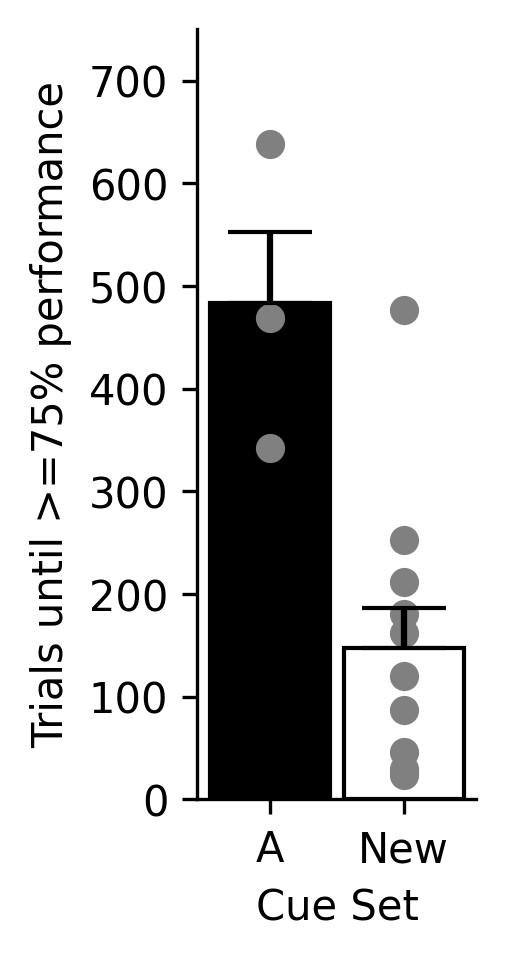

p-value: 0.03875894384100322
Group A: Mean = 483.0, N = 3, SEM = 70.00158728359109
Group New: Mean = 146.8181818181818, N = 11, SEM = 38.96254149011452


In [28]:
import figrid as fg
import matplotlib.pyplot as plt
from linear2ac.colors import cueset_color
import numpy as np
from scipy.stats import ttest_ind

grayscale = False
accuracy_threshold = 75

results_A = results[:,0].flatten()
results_new = results[:,1:].flatten()
results_new_no_nan  = results_new [~np.isnan(results_new )]


# Create figure and axes
fig = plt.figure(figsize=(1.2,4),edgecolor='black',dpi=300,facecolor='white')
axs = {
    'plot': fg.place_axes_on_grid(fig, xspan=[0, 1], yspan=[0.15, 1]),
}


# Define data
cueset_titles = ['A', 'New']
m_A = np.mean(results_A)
m_new = np.mean(results_new_no_nan)
sem_A = np.nanstd(results_A)/np.sqrt(len(results_A))
sem_new = np.nanstd(results_new)/np.sqrt(len(results_new_no_nan))


# plot averages.
ax = axs['plot']

# Set the colors for the bars
bar_colors = ['black', 'white']

ax.bar(cueset_titles, [m_A, m_new], yerr=[[0, 0], [sem_A, sem_new]], align='center', color=bar_colors, edgecolor='black', capsize=10, width=0.9)

# plot individual dots
for i, r in enumerate(results_A):
    ax.scatter('A', r, color='gray', alpha=1)
for i, r in enumerate(results_new):
    ax.scatter('New', r, color='gray', alpha=1)

# format axis.
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Cue Set')
ax.set_ylabel(f"Trials until >={accuracy_threshold}% performance")
ax.set_ylim(0, 750)
plt.savefig("bargraph.pdf", format='pdf', dpi=500, bbox_inches='tight')
plt.show()


# Perform unpaired t-test
t_stat, p_value = ttest_ind(results_A, results_new_no_nan, equal_var=False)

# Print p-value
print("p-value:", p_value)
print(f"Group A: Mean = {m_A}, N = {len(results_A)}, SEM = {sem_A}")
print(f"Group New: Mean = {m_new}, N = {len(results_new_no_nan)}, SEM = {sem_new}")

